In [41]:
#%load_ext lab_black

# Using GloVe for text classification

In this pre-filled notebook, we use GloVe embeddings to train a classifier for sentiment analysis. For every review in the IMDB dataset we:
1. Tokenize the review into tokens.
2. Get the pre-trained GloVe vector for every token in the review (if they are in the voabulary of GloVe).
3. Average the vectors over the full review.
4. Send the vector through a logistic regression.

This time, we will batch the inputs instead of updating the weights once per epoch.

Before starting, to make your experiments reproducible, make sure to [force the random seed](https://pytorch.org/docs/stable/notes/randomness.html).

In [61]:
from copy import deepcopy
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import torch
from torch import nn
import torchtext
from torchtext import vocab
from torchtext.vocab import GloVe
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

random_seed = 42

## Using GloVe (1 point)

Let's get familier with GloVe embeddings. We download a small version of GloVe trained of 6 billion words, and use vectors of size 300.

The [torchtext documentation](https://pytorch.org/text/stable/vocab.html#glove) being quite poor, you can find details on the different pre-trained vectors on the [Stanford page](https://nlp.stanford.edu/projects/glove/).

In [43]:
glove = GloVe(name="6B", dim=300)
len(glove.stoi)

400000

In [44]:
glove.stoi["cat"], glove.itos[5450], glove.vectors[glove.stoi["cat"]].shape

(5450, 'cat', torch.Size([300]))

In [45]:
glove.itos[:5]

['the', ',', '.', 'of', 'to']

Notice that punctuations are part of GloVe's vocabulary.

To compare two words, we can look at their cosine similarity.

In [46]:
words = ["cat", "cats", "dog", "fridge"]
for word in words[1:]:
    similarity = torch.cosine_similarity(
        glove.vectors[glove.stoi[words[0]]].reshape(1, -1),
        glove.vectors[glove.stoi[word]].reshape(1, -1),
    ).item()  # .item() is used to turn a tensor of a single value to a float
    print(f"{words[0]} x {word} = {similarity}")

cat x cats = 0.6815836429595947
cat x dog = 0.6816746592521667
cat x fridge = 0.09630905091762543


**\[1 point\] Find the closest word to "cat" in the whole vocabulary.**

In [47]:
word = "cat"
# your code

# find the most similar word to "cat" in the vocabulary
max_similarity = -1
most_similar_word = None
second_max_similarity = -1
second_most_similar_word = None
for w in glove.itos:
    similarity = torch.cosine_similarity(
        glove.vectors[glove.stoi[word]].reshape(1, -1),
        glove.vectors[glove.stoi[w]].reshape(1, -1),
    ).item()
    if similarity > max_similarity:
        second_max_similarity = max_similarity
        second_most_similar_word = most_similar_word
        max_similarity = similarity
        most_similar_word = w

print(f"{word} x {most_similar_word} = {max_similarity}")
print(f"{word} x {second_most_similar_word} = {second_max_similarity}")


cat x cat = 1.0
cat x dog = 0.6816746592521667


The closest word to cat is indeed cat, the second one (or the first one wich is not cat) is the word dog


## Dataset and split

As we keep the test set for final evaluation, we need to split the training set into a training and validation set. We make sure the split is **stratified** by class (same proportion of class in each split).

In [48]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (/home/pili/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 69.31it/s]
Loading cached split indices for dataset at /home/pili/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-5f37fd0866e4f89f.arrow and /home/pili/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

## Prepare the inputs

### Text processing pipeline (2 points)

For a given entry, we want to
1. Tokenize the text.
2. Get the vectors for each token.
3. Average them.

For tokenization, let's use the "basic_english" tokenizer from torchtext.

In [49]:
tokenizer = get_tokenizer("basic_english", language="en")

**\[2 points\] Fill the `preprocess_text` function so it returns the mean of the GloVe vectors of all the tokens within a review.**

The two following functions can help.
* [torch.stack](https://pytorch.org/docs/stable/generated/torch.stack.html)
* [torch.mean](https://pytorch.org/docs/stable/generated/torch.mean.html)

In [50]:
def vectorize_text(
    text: str, vocabulary: vocab.Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Turn a string into the average of the vectors of its tokens.
    Args:
        text: the input text.
        vocabulary: a pre-trained Vocab object.
        tokenizer: a tokenizer taking a text as input and returning a list of tokens.
    Returns:
        The average tensor over the tokens of the whole text.
    """
    # Your code

    # tokenize the text
    tokens = tokenizer(text)
    # get the vectors of the tokens
    vectors = []
    for token in tokens:
        if token in vocabulary.stoi:
            vectors.append(vocabulary.vectors[vocabulary.stoi[token]])
    # average the vectors
    average = torch.mean(torch.stack(vectors), dim=0)
    return average

In [51]:
text_pipeline = partial(vectorize_text, vocabulary=glove, tokenizer=tokenizer)
assert text_pipeline("some text.").shape == torch.Size([300])

Now we turn our 3 sets into vectors and labels.

Our data are quite small, so we can keep everything in RAM.

In [52]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

100%|██████████| 25000/25000 [00:18<00:00, 1385.06it/s]


### Batch processing (1 point)

Instead of doing one update per epoch, we feed the model batches of texts between each update. To do so, we use a simple data generator.

**\[1 point\] Fill the generator function.**


In [53]:
def data_generator(
    X: List[torch.tensor], y: List[int], batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    # Your code
    # yield the the returning values
    for i in range(0, len(X), batch_size):
        yield torch.stack(X[i : i + batch_size]), torch.tensor(y[i : i + batch_size])


In [54]:
train_gen = lambda: data_generator(X_train, y_train, batch_size=32)
for X, y in train_gen():
    assert X.shape == torch.Size([32, 300])
    assert y.shape == torch.Size([32])
    break

## The classifier (1 point)

We create a very simple classifier corresponding a logistic regression.

**\[1 point\] Fill the classifier's code. The forward function needs to return a logit and not the output of a sigmoid.**

In [55]:
class SimpleClassifer(nn.Module):
    """
    A simple linear classifier.
    """

    def __init__(self, embedding_size: int, nb_classes: int) -> None:
        """
        Args:
            embedding_size: the dimension of the input embeddings.
        nb_classes: the output dimension.
        """
        # your code
        super(SimpleClassifer, self).__init__()
        self.linear = nn.Linear(embedding_size, nb_classes)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: an input tensor
        Returns:
            Logits.
        """
        # your code
        # return sigmoid logits
        return torch.sigmoid(self.linear(x))
        

## Training (3 points)

We put everything above together and train the classifier.

In [56]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [57]:
train_gen = lambda: data_generator(X_train, y_train)
valid_gen = lambda: data_generator(X_valid, y_valid)
test_gen = lambda: data_generator(X_test, y_test)

**\[3 points\] Fill the following cells. Make sure you save the best model evaluated on the validation set.**
* The `deepcopy` function might help.

In [62]:
import copy

In [63]:
model = SimpleClassifer(300, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
# You can use another optimizer if you want.
optimizer = torch.optim.Adam(model.parameters())

In [64]:
nb_epochs = 50
train_losses, valid_losses = [], []

best_model = model
best_validation_loss = np.Inf

for epoch in tqdm(range(nb_epochs)):

    # training
    model.train()
    # training loop
    x = train_gen()
    loss_batchs = []
    for X, y in x:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(torch.squeeze(output), y.float())
        loss.backward()
        optimizer.step()
        loss_batchs.append(loss.item())
    train_losses.append(np.mean(loss_batchs))
    
    # validation
    model.eval()
    with torch.no_grad():
        x = valid_gen()
        loss_batchs_valid = []
        for X, y in x:
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = criterion(torch.squeeze(output), y.float())
            loss_batchs_valid.append(loss.item())
        
        valid_losses.append(np.mean(loss_batchs_valid))
        print(f"Epoch {epoch} - Validation loss: {np.mean(valid_losses)}")
        
        if np.mean(valid_losses) < best_validation_loss:
            best_model = model
            best_validation_loss = np.mean(valid_losses)

model = copy.deepcopy(best_model)


  2%|▏         | 1/50 [00:00<00:13,  3.74it/s]

Epoch 0 - Validation loss: 0.6865806120216467


  4%|▍         | 2/50 [00:00<00:12,  3.77it/s]

Epoch 1 - Validation loss: 0.6802675553188202


  6%|▌         | 3/50 [00:00<00:12,  3.89it/s]

Epoch 2 - Validation loss: 0.6750318440915167


  8%|▊         | 4/50 [00:01<00:12,  3.77it/s]

Epoch 3 - Validation loss: 0.6707071880246425


 10%|█         | 5/50 [00:01<00:12,  3.61it/s]

Epoch 4 - Validation loss: 0.6670791252403503


 12%|█▏        | 6/50 [00:01<00:11,  3.67it/s]

Epoch 5 - Validation loss: 0.6640026408016303


 14%|█▍        | 7/50 [00:01<00:11,  3.63it/s]

Epoch 6 - Validation loss: 0.6611212275047754


 16%|█▌        | 8/50 [00:02<00:11,  3.73it/s]

Epoch 7 - Validation loss: 0.6585971711642423


 18%|█▊        | 9/50 [00:02<00:10,  3.78it/s]

Epoch 8 - Validation loss: 0.6562857730795285


 20%|██        | 10/50 [00:02<00:10,  3.73it/s]

Epoch 9 - Validation loss: 0.6541524937578067


 22%|██▏       | 11/50 [00:02<00:10,  3.72it/s]

Epoch 10 - Validation loss: 0.6522295520218659


 24%|██▍       | 12/50 [00:03<00:09,  3.81it/s]

Epoch 11 - Validation loss: 0.6504392784302402


 26%|██▌       | 13/50 [00:03<00:09,  3.88it/s]

Epoch 12 - Validation loss: 0.6487258999795087


 28%|██▊       | 14/50 [00:03<00:09,  3.89it/s]

Epoch 13 - Validation loss: 0.6471599976348271


 30%|███       | 15/50 [00:03<00:08,  3.94it/s]

Epoch 14 - Validation loss: 0.6456926672068878


 32%|███▏      | 16/50 [00:04<00:08,  3.96it/s]

Epoch 15 - Validation loss: 0.6443536379344904


 34%|███▍      | 17/50 [00:04<00:08,  3.93it/s]

Epoch 16 - Validation loss: 0.6430611755571904


 36%|███▌      | 18/50 [00:04<00:08,  3.92it/s]

Epoch 17 - Validation loss: 0.6418205956913272


 38%|███▊      | 19/50 [00:04<00:07,  3.93it/s]

Epoch 18 - Validation loss: 0.6406557559167784


 40%|████      | 20/50 [00:05<00:07,  3.90it/s]

Epoch 19 - Validation loss: 0.6395229037969735


 42%|████▏     | 21/50 [00:05<00:08,  3.58it/s]

Epoch 20 - Validation loss: 0.6384863564380199


 44%|████▍     | 22/50 [00:05<00:08,  3.48it/s]

Epoch 21 - Validation loss: 0.6374738582414772


 46%|████▌     | 23/50 [00:06<00:07,  3.50it/s]

Epoch 22 - Validation loss: 0.6365396107078358


 48%|████▊     | 24/50 [00:06<00:07,  3.53it/s]

Epoch 23 - Validation loss: 0.6356632261202847


 50%|█████     | 25/50 [00:06<00:06,  3.62it/s]

Epoch 24 - Validation loss: 0.6348037859284954


 52%|█████▏    | 26/50 [00:06<00:06,  3.70it/s]

Epoch 25 - Validation loss: 0.6339900496396174


 54%|█████▍    | 27/50 [00:07<00:06,  3.79it/s]

Epoch 26 - Validation loss: 0.6332009123107909


 56%|█████▌    | 28/50 [00:07<00:05,  3.79it/s]

Epoch 27 - Validation loss: 0.632453240244035


 58%|█████▊    | 29/50 [00:07<00:05,  3.83it/s]

Epoch 28 - Validation loss: 0.6317068168076478


 60%|██████    | 30/50 [00:07<00:05,  3.75it/s]

Epoch 29 - Validation loss: 0.6310186501774312


 62%|██████▏   | 31/50 [00:08<00:05,  3.73it/s]

Epoch 30 - Validation loss: 0.6303280145572837


 64%|██████▍   | 32/50 [00:08<00:04,  3.79it/s]

Epoch 31 - Validation loss: 0.629659834952586


 66%|██████▌   | 33/50 [00:08<00:04,  3.72it/s]

Epoch 32 - Validation loss: 0.6290309395230523


 68%|██████▊   | 34/50 [00:09<00:04,  3.76it/s]

Epoch 33 - Validation loss: 0.6284445138873568


 70%|███████   | 35/50 [00:09<00:03,  3.83it/s]

Epoch 34 - Validation loss: 0.6278719235052295


 72%|███████▏  | 36/50 [00:09<00:03,  3.93it/s]

Epoch 35 - Validation loss: 0.6273225454240511


 74%|███████▍  | 37/50 [00:09<00:03,  3.98it/s]

Epoch 36 - Validation loss: 0.6267641239351774


 76%|███████▌  | 38/50 [00:10<00:03,  3.96it/s]

Epoch 37 - Validation loss: 0.6262431094261212


 78%|███████▊  | 39/50 [00:10<00:02,  4.01it/s]

Epoch 38 - Validation loss: 0.6257336516503356


 80%|████████  | 40/50 [00:10<00:02,  4.05it/s]

Epoch 39 - Validation loss: 0.6252412197791088


 82%|████████▏ | 41/50 [00:10<00:02,  4.07it/s]

Epoch 40 - Validation loss: 0.6247590128560976


 84%|████████▍ | 42/50 [00:11<00:01,  4.10it/s]

Epoch 41 - Validation loss: 0.624293918573643


 86%|████████▌ | 43/50 [00:11<00:01,  4.09it/s]

Epoch 42 - Validation loss: 0.6238475005470582


 88%|████████▊ | 44/50 [00:11<00:01,  4.09it/s]

Epoch 43 - Validation loss: 0.623422871017532


 90%|█████████ | 45/50 [00:11<00:01,  4.00it/s]

Epoch 44 - Validation loss: 0.6230044936551664


 92%|█████████▏| 46/50 [00:12<00:01,  3.92it/s]

Epoch 45 - Validation loss: 0.6225798033720502


 94%|█████████▍| 47/50 [00:12<00:00,  3.89it/s]

Epoch 46 - Validation loss: 0.6221770687403114


 96%|█████████▌| 48/50 [00:12<00:00,  3.82it/s]

Epoch 47 - Validation loss: 0.6217957912625907


 98%|█████████▊| 49/50 [00:12<00:00,  3.85it/s]

Epoch 48 - Validation loss: 0.6214086350083087


100%|██████████| 50/50 [00:13<00:00,  3.81it/s]

Epoch 49 - Validation loss: 0.6210391657671351


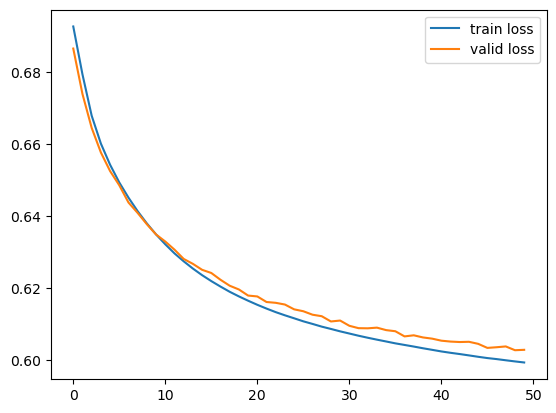

In [65]:
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()

## Evaluation (3 point)

**\[1 point\] Compute the accuracy for the 3 splits (training, validation, test).**

In [66]:
# Your code
# compute the accuracy on the 3 splits
def accuracy(model, X, y):
    with torch.no_grad():
        X = torch.stack(X).to(device)
        y = torch.tensor(y).to(device)
        output = model(X)
        output = torch.squeeze(output)
        output = torch.round(output)
        return torch.sum(output == y).item() / len(y)
    
print(f"Accuracy on the training set: {accuracy(model, X_train, y_train)}")
print(f"Accuracy on the validation set: {accuracy(model, X_valid, y_valid)}")
print(f"Accuracy on the test set: {accuracy(model, X_test, y_test)}")

Accuracy on the training set: 0.80525
Accuracy on the validation set: 0.8016
Accuracy on the test set: 0.79692


**\[1 point\] For two wrongly classified samples, try guessing why the model was wrong.**

In [67]:
# take two wrong predictions
wrong_predictions = []
for i in range(len(X_test)):
    if torch.round(torch.squeeze(model(torch.stack(X_test).to(device))[i])) != y_test[i]:
        wrong_predictions.append(i)
        break

# from the end
for i in range(len(X_test) - 1, 0, -1):
    if torch.round(torch.squeeze(model(torch.stack(X_test).to(device))[i])) != y_test[i]:
        wrong_predictions.append(i)
        break

# print the wrong predictions
for i in wrong_predictions:
    print(f"Text: {test_df['text'][i]}")
    print(f"Label: {test_df['label'][i]}")
    print(f"Prediction: {torch.round(torch.squeeze(model(torch.stack(X_test).to(device))[i]))}")

Text: Isaac Florentine has made some of the best western Martial Arts action movies ever produced. In particular US Seals 2, Cold Harvest, Special Forces and Undisputed 2 are all action classics. You can tell Isaac has a real passion for the genre and his films are always eventful, creative and sharp affairs, with some of the best fight sequences an action fan could hope for. In particular he has found a muse with Scott Adkins, as talented an actor and action performer as you could hope for. This is borne out with Special Forces and Undisputed 2, but unfortunately The Shepherd just doesn't live up to their abilities.<br /><br />There is no doubt that JCVD looks better here fight-wise than he has done in years, especially in the fight he has (for pretty much no reason) in a prison cell, and in the final showdown with Scott, but look in his eyes. JCVD seems to be dead inside. There's nothing in his eyes at all. It's like he just doesn't care about anything throughout the whole film. And 

### Above we have two examples of wrong predictions :  
#### The first one :  
Isaac Florentine has made some of the best western Martial Arts action movies ever produced. In particular US Seals 2, Cold Harvest, Special Forces and Undisputed 2 are all action classics. You can tell Isaac has a real passion for the genre and his films are always eventful, creative and sharp affairs, with some of the best fight sequences an action fan could hope for. In particular he has found a muse with Scott Adkins, as talented an actor and action performer as you could hope for. This is borne out with Special Forces and Undisputed 2, but unfortunately The Shepherd just doesn't live up to their abilities.<br /><br />There is no doubt that JCVD looks better here fight-wise than he has done in years, especially in the fight he has (for pretty much no reason) in a prison cell, and in the final showdown with Scott, but look in his eyes. JCVD seems to be dead inside. There's nothing in his eyes at all. It's like he just doesn't care about anything throughout the whole film. And this is the leading man.<br /><br />There are other dodgy aspects to the film, script-wise and visually, but the main problem is that you are utterly unable to empathise with the hero of the film. A genuine shame as I know we all wanted this film to be as special as it genuinely could have been. There are some good bits, mostly the action scenes themselves. This film had a terrific director and action choreographer, and an awesome opponent for JCVD to face down. This could have been the one to bring the veteran action star back up to scratch in the balls-out action movie stakes.<br /><br />Sincerely a shame that this didn't happen.  

#### is labelled as negative but our code labelled it as positive, it may be because the author of the review spend a lot of time to compliment the author although this film disapointed him.

#### The second one :  
I caught this movie on the Sci-Fi channel recently. It actually turned out to be pretty decent as far as B-list horror/suspense films go. Two guys (one naive and one loud mouthed a**) take a road trip to stop a wedding but have the worst possible luck when a maniac in a freaky, make-shift tank/truck hybrid decides to play cat-and-mouse with them. Things are further complicated when they pick up a ridiculously whorish hitchhiker. What makes this film unique is that the combination of comedy and terror actually work in this movie, unlike so many others. The two guys are likable enough and there are some good chase/suspense scenes. Nice pacing and comic timing make this movie more than passable for the horror/slasher buff. Definitely worth checking out.

#### is labelled as positive but our code labelled it as negative, it may comes from the fact that the recap of the story in the review describes a "negative" story, but the film is still a good film for the author

**\[1 point\] Code a `predict` function which take some text as input and returns a prediction class and score (the output of the sigmoid).**

In [68]:
def predict(
    text: str,
    text_pipeline: Callable[[str], torch.Tensor],
    model: nn.Module,
    device: str,
) -> Tuple[int, float]:
    """
    Return the predicted class and score for a given input.
    Args:
        text: a given review.
        text_pipeline: a function taking a text as input and returning a tensor (model's input).
        model: a pre-trained model.
        device: the device on which the computation occurs.
    Returns:
        A tuple (label, score).
    """
    # Your code
    tensor = text_pipeline(text).to(device)
    output = model(tensor)
    output = torch.squeeze(output)
    label = torch.round(output)
    return int(label), float(output.item())


In [69]:
text = "In my long years as a movie reviewers, I have seen good and bad movies. But nothing as controversially in the middle."
#text = "it's the best movie ever, love it so much"
predict(text, text_pipeline, model, device)

(0, 0.22268378734588623)

## Bonus

Modify the classifier. Instead of using a simple logistic regression, create a multilayer perceptron. Something like `input -> linear(embedding_size, 128) -> activation function -> linear(128, nb_classes) -> output`, for a two layer perceptron.

For the activation function, you can use [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) or [another non-linear activation function](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) of your choice.

Train your new classifier, look at the loss, and compare its accuracy with the logistic regression. Keep the model with the best validation loss.

In [70]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.fc2(out)
        return out

In [73]:
mlp_model = MLPClassifier(input_size=300, hidden_size=128, output_size=1)
nb_epochs = 50
train_losses, valid_losses = [], []

best_model = mlp_model
best_validation_loss = np.Inf



# Train the model with MLPClassifier
for epoch in tqdm(range(nb_epochs)):
    # training
    train_loader = train_gen()
    loss_batchs = []
    for X, y in train_loader:
        X, y = X.to(device), y.to(device).reshape(-1, 1)
        optimizer.zero_grad()
        output = mlp_model(X)
        loss = criterion(output, y.float())
        loss.backward()
        optimizer.step()
        loss_batchs.append(loss.item())
    train_losses.append(np.mean(loss_batchs))

    # validation
    mlp_model.eval()
    x = valid_gen()
    loss_batchs_valid = []
    for X, y in x:
        X, y = X.to(device), y.to(device).reshape(-1, 1)
        optimizer.zero_grad()
        output = mlp_model(X)
        loss = criterion(output, y.float())
        loss.backward()
        optimizer.step()
        loss_batchs_valid.append(loss.item())
    
    
    valid_losses.append(np.mean(loss_batchs_valid))
    print(f"Epoch {epoch} - Validation loss: {np.mean(valid_losses)}")
    
    if np.mean(valid_losses) < best_validation_loss:
        best_model = mlp_model
        best_validation_loss = np.mean(valid_losses)

mlp_model = copy.deepcopy(best_model)

  2%|▏         | 1/50 [00:00<00:15,  3.09it/s]

Epoch 0 - Validation loss: 0.693163020215976


  4%|▍         | 2/50 [00:00<00:15,  3.10it/s]

Epoch 1 - Validation loss: 0.6931789534486783


  6%|▌         | 3/50 [00:00<00:14,  3.16it/s]

Epoch 2 - Validation loss: 0.6931583076525646


  8%|▊         | 4/50 [00:01<00:14,  3.15it/s]

Epoch 3 - Validation loss: 0.6931543624514986


 10%|█         | 5/50 [00:01<00:14,  3.05it/s]

Epoch 4 - Validation loss: 0.6931638312187923


 12%|█▏        | 6/50 [00:01<00:14,  3.09it/s]

Epoch 5 - Validation loss: 0.6931600210013662


 14%|█▍        | 7/50 [00:02<00:14,  3.02it/s]

Epoch 6 - Validation loss: 0.6931602962457449


 16%|█▌        | 8/50 [00:02<00:14,  2.96it/s]

Epoch 7 - Validation loss: 0.6931649113821375


 18%|█▊        | 9/50 [00:02<00:13,  2.98it/s]

Epoch 8 - Validation loss: 0.6931595045121443


 20%|██        | 10/50 [00:03<00:13,  3.04it/s]

Epoch 9 - Validation loss: 0.6931610243335651


 22%|██▏       | 11/50 [00:03<00:12,  3.08it/s]

Epoch 10 - Validation loss: 0.6931619174437641


 24%|██▍       | 12/50 [00:03<00:12,  3.09it/s]

Epoch 11 - Validation loss: 0.6931641559312297


 26%|██▌       | 13/50 [00:04<00:11,  3.10it/s]

Epoch 12 - Validation loss: 0.6931622255555208


 28%|██▊       | 14/50 [00:04<00:11,  3.06it/s]

Epoch 13 - Validation loss: 0.6931617249403355


 30%|███       | 15/50 [00:04<00:11,  3.11it/s]

Epoch 14 - Validation loss: 0.6931620295893108


 32%|███▏      | 16/50 [00:05<00:10,  3.12it/s]

Epoch 15 - Validation loss: 0.6931623508026645


 34%|███▍      | 17/50 [00:05<00:10,  3.15it/s]

Epoch 16 - Validation loss: 0.6931608984558802


 36%|███▌      | 18/50 [00:05<00:10,  3.18it/s]

Epoch 17 - Validation loss: 0.693163028399487


 38%|███▊      | 19/50 [00:06<00:09,  3.20it/s]

Epoch 18 - Validation loss: 0.6931651359510789


 40%|████      | 20/50 [00:06<00:09,  3.21it/s]

Epoch 19 - Validation loss: 0.6931642406115865


 42%|████▏     | 21/50 [00:06<00:09,  3.21it/s]

Epoch 20 - Validation loss: 0.6931641743260512


 44%|████▍     | 22/50 [00:07<00:08,  3.22it/s]

Epoch 21 - Validation loss: 0.6931621015209921


 46%|████▌     | 23/50 [00:07<00:08,  3.22it/s]

Epoch 22 - Validation loss: 0.6931632285763832


 48%|████▊     | 24/50 [00:07<00:08,  3.23it/s]

Epoch 23 - Validation loss: 0.693162105771893


 50%|█████     | 25/50 [00:07<00:07,  3.24it/s]

Epoch 24 - Validation loss: 0.6931604899266723


 52%|█████▏    | 26/50 [00:08<00:07,  3.20it/s]

Epoch 25 - Validation loss: 0.6931610874893734


 54%|█████▍    | 27/50 [00:08<00:07,  3.21it/s]

Epoch 26 - Validation loss: 0.6931608563944203


 56%|█████▌    | 28/50 [00:08<00:06,  3.22it/s]

Epoch 27 - Validation loss: 0.693160734996132


 58%|█████▊    | 29/50 [00:09<00:06,  3.19it/s]

Epoch 28 - Validation loss: 0.6931611699060952


 60%|██████    | 30/50 [00:09<00:06,  3.08it/s]

Epoch 29 - Validation loss: 0.6931618899170254


 62%|██████▏   | 31/50 [00:09<00:06,  2.98it/s]

Epoch 30 - Validation loss: 0.6931616566326674


 64%|██████▍   | 32/50 [00:10<00:05,  3.02it/s]

Epoch 31 - Validation loss: 0.693162988183225


 66%|██████▌   | 33/50 [00:10<00:05,  3.00it/s]

Epoch 32 - Validation loss: 0.6931640966429579


 68%|██████▊   | 34/50 [00:10<00:05,  3.04it/s]

Epoch 33 - Validation loss: 0.6931647262398157


 70%|███████   | 35/50 [00:11<00:04,  3.06it/s]

Epoch 34 - Validation loss: 0.6931654380710696


 72%|███████▏  | 36/50 [00:11<00:04,  2.82it/s]

Epoch 35 - Validation loss: 0.6931652574571243


 74%|███████▍  | 37/50 [00:11<00:04,  2.91it/s]

Epoch 36 - Validation loss: 0.69316412630334


 76%|███████▌  | 38/50 [00:12<00:04,  2.99it/s]

Epoch 37 - Validation loss: 0.6931646580648949


 78%|███████▊  | 39/50 [00:12<00:03,  2.95it/s]

Epoch 38 - Validation loss: 0.6931630899348173


 80%|████████  | 40/50 [00:12<00:03,  2.98it/s]

Epoch 39 - Validation loss: 0.6931624769784842


 82%|████████▏ | 41/50 [00:13<00:02,  3.05it/s]

Epoch 40 - Validation loss: 0.6931619309056745


 84%|████████▍ | 42/50 [00:13<00:02,  3.10it/s]

Epoch 41 - Validation loss: 0.6931627049730299


 86%|████████▌ | 43/50 [00:13<00:02,  3.15it/s]

Epoch 42 - Validation loss: 0.6931626093226915


 88%|████████▊ | 44/50 [00:14<00:01,  3.12it/s]

Epoch 43 - Validation loss: 0.6931627647995465


 90%|█████████ | 45/50 [00:14<00:01,  3.03it/s]

Epoch 44 - Validation loss: 0.6931618766420206


 92%|█████████▏| 46/50 [00:14<00:01,  3.08it/s]

Epoch 45 - Validation loss: 0.6931623094169692


 94%|█████████▍| 47/50 [00:15<00:01,  2.96it/s]

Epoch 46 - Validation loss: 0.69316349113225


 96%|█████████▌| 48/50 [00:15<00:00,  2.93it/s]

Epoch 47 - Validation loss: 0.6931634796051717


 98%|█████████▊| 49/50 [00:15<00:00,  2.99it/s]

Epoch 48 - Validation loss: 0.6931622041134876


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]

Epoch 49 - Validation loss: 0.693162221802268


Accuracy on the training set: 0.80525
Accuracy on the validation set: 0.8016
Accuracy on the test set: 0.79692


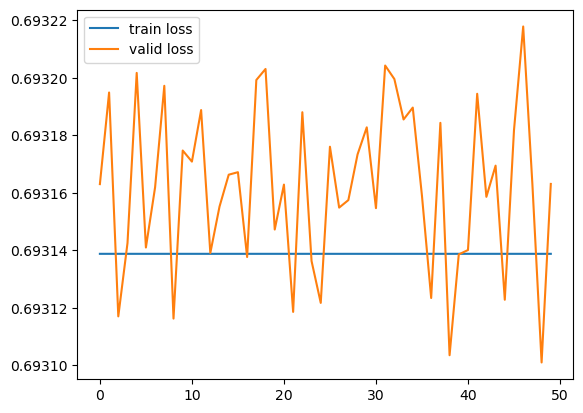

In [74]:
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()

print(f"Accuracy on the training set: {accuracy(model, X_train, y_train)}")
print(f"Accuracy on the validation set: {accuracy(model, X_valid, y_valid)}")
print(f"Accuracy on the test set: {accuracy(model, X_test, y_test)}")